# RL с блэкджэком и Дастином Хоффманом

Эта тетрадка посвящена решению первого домашнего задания курса С. Николенко по обучению с подкреплением в рамках 3 семестра MADE.
Предлагается обучаться играть в очень простую, но  популярную игру: [**блекджек**](https://en.wikipedia.org/wiki/Blackjack). 

## Часть первая, с блекджеком и стратегиями

### Введение

> давайте начнём с самой базовой версии, которая реализована в OpenAI Gym

In [1]:
from gym.envs.toy_text.blackjack import BlackjackEnv

Базовые правила, реализованные в `gym` (из docstring-а):

- цель игры - получить на руки карты, сумма которых как можно ближе к 21, но при этом не больше 21.
- стоимости карт: 
    - от 2 до 10 для карт с цифрами
    - 10 для валетов (Jack), дам (Queen) и королей (King)
    - 11 для туза (ace), если при этом сумма очков не выходит за 21 (такой случай называется usable ace), 1 - если выходит
- игра начинаеися с того, что раздается по 2 карты дилеру и игроку - игроку обе карты в открытую, дилеру - только одну карту в открытую
- каждый ход игрок может либо попросить еще карту (hit (`action == 1`)), либо остановиться (stick (`action == 0`))
- если игрок в очередной раз попросил карту и сумма его очков превысила 21 - он проиграл (bust), и его награда равна -1
- если игрок решил остановиться, дилер открывает свою закрытую карту и тянет карты в открытую до тех пор, пока его сумма очков не становится >= 17
- если дилер превысил 21 (goes bust) - он проиграл, награда игрока = 1
- если нет, то победитель определяется тем, у кого сумма очков ближе к 21. Если сумма очков дилера равна сумме очков игрока, засчитывается ничья, награда = 0

Кроме того, в реализации `gym` для `BlackjackEnv` есть еще две настройки - `natural=False` и `sab=False`.

- `natural=False` включает/выключает в правила награду в 1.5 за natural руку у игрока (natural - рука, сумма очков в которой равна 21 с первых двух карт)
- `sab=False` включает/выключает полную поддердку правил из примера 5.1 книги Reinforcement Learning: An Introduction (Sutton, Barto). Единственное различие, которое я увидел, заключается в том, как я понял, что если и у дилера и у игрока natural-рука, то это ничья

Попробуем позапускать:

In [2]:
env = BlackjackEnv(natural=True)
env.seed(11)
env.reset()

(9, 3, False)

Первое число - сумма на руке игрока, второе - стоимость открытой карты дилера, 3 - есть ли usable_ace.
Попросим еще карту

In [3]:
hit = 1
stick = 0
env.step(action=hit)

((19, 3, False), 0.0, False, {})

Новые 2 числа - это текущая награда и закончился ли эпизод

In [4]:
env.step(action=stick)

((19, 3, False), 0.0, True, {})

Ничья :)

### 1.1 Наивная стратегия

 > Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [5]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from abc import ABC, abstractmethod
from pprint import pprint
from itertools import product
from multiprocessing import Pool
import os
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10,6)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})

Каждый игрок - это наследник класса `BasePlayer`, у которого реализован метод `strategy`, принимающий как аргумент предыдущее состояние среды и возвращающий `action`.
Для наивного игрока этот метод выглядит совсем просто:

In [6]:
class BasePlayer(ABC):
    @abstractmethod
    def strategy(self, previous_state):
        raise NotImplementedError("Implement me in subclass")
    
    def action(self, previous_state):
        return self.strategy(previous_state)
    
    def set_training(self):
        self.training = True
    
    def set_playing(self):
        self.training = False

class NaivePlayer(BasePlayer):
    def strategy(self, previous_state):
        my_sum = previous_state[0]
        return int(my_sum < 19)
    def __str__(self):
        return f'Player'

Класс `BlackJackGame` является по сути оберткой над `BlackJackEnv`, позволяющей запустить один эпизод для игрока (функция `run_episode`), а также Монте-Карло оценку игрока (`mc_check`). Монте-Карло оценка просто [итеративно](https://www.heikohoffmann.de/htmlthesis/node134.html) считает среднюю награду:

$$\overline{x}_0 = 0$$
$$\overline{x}_{i + 1} = \overline{x}_{i} + \frac{x_{i + 1} - \overline{x}_{i}}{i + 1}$$

In [35]:
class BlackJackGame:
    def __init__(self, env):
        self.env = env
    
    def run_episode(self, player, return_history=False):
        episode_history = []
        prev_env_return = self.env.reset()
        prev_env_return = (prev_env_return, 0.0, False, {})
        state, reward, episode_ended, _ = prev_env_return
        episode_history.append((prev_env_return, None))
        while not episode_ended:
            action = player.action(state)
            prev_env_return = self.env.step(action)
            state, reward, episode_ended, _ = prev_env_return
            episode_history.append((prev_env_return, action))
        if return_history:
            return reward, episode_history
        else:
            return reward
    
    def mc_check(self, player, n_iter=100_000, use_tqdm=True):
        mean_reward = self.run_episode(player, return_history=False)
        for i in tqdm(range(n_iter), total=n_iter, desc=f'Checking {player}', disable=not use_tqdm):
            reward = self.run_episode(player, return_history=False)
            mean_reward += (reward - mean_reward) / (i + 1)
        return mean_reward

In [36]:
nplayer = NaivePlayer()
env = BlackjackEnv()
game = BlackJackGame(env)

Запустим 100к итераций Монте-Карло оценки, чтобы оценить средний выигрыш наивного игрока

In [37]:
mean_reward = game.mc_check(nplayer, n_iter=100000, use_tqdm=True)
print(f'Mean reward = {mean_reward: .4f}')

Checking Player:   0%|          | 0/100000 [00:00<?, ?it/s]

Mean reward = -0.2025


### 1.2 RL без модели

> Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Для релизации понадобится хранить историю эпизода. Я решил хранить историю следующим образом - каждый элемент истории эпизода это:
- состояние среды
- награда
- закончилась ли игра
- какой то вечно пустой словарик из OpenAI Gym
- action, который привел игрока в это состояние

In [10]:
reward, episode_history = game.run_episode(nplayer, return_history=True)
pprint(episode_history)

[(((13, 4, False), 0.0, False, {}), None),
 (((23, 4, False), -1.0, True, {}), 1)]


В качестве алгоритма RL без модели я выбрал off-policy Monte Carlo control с мягкими стратегиями

In [14]:
from collections import defaultdict

class OffPolicySoftGreedyMCControlPlayer(BasePlayer):
    
    def __init__(self, action_dim, eps=1e-3, gamma=1):
        self.set_training()
        self.eps = eps
        self.gamma = gamma
        self.q = defaultdict(lambda: np.zeros(action_dim))
        self.c = defaultdict(lambda: np.zeros(action_dim))
        self.action_dim = action_dim
        self.total_iter_learning = 0
    
    def __str__(self):
        return f'Player(gamma={self.gamma}, eps={self.eps})'
    
    def reset(self):
        self.total_iter_learning = 0
        self.q = defaultdict(lambda: np.zeros(action_dim))
        self.c = defaultdict(lambda: np.zeros(action_dim))
    
    def update_q(self, episode_history):
        self.total_iter_learning += 1
        prob_greedy_action = 1 - (self.action_dim - 1) * self.eps / self.action_dim
        if not self.training:
            raise ValueError('Player must be in training mode for updating Q. Use player.set_training()')
        else:
            g = 0
            w = 1
            for t in np.arange(len(episode_history) - 2, -1, -1):
                (state, reward, is_done, _), prev_action = episode_history[t]
                (state_next, reward_next, is_done_next, _), prev_action = episode_history[t + 1]
                g = self.gamma * g + reward_next
                self.c[state][prev_action] += w
                self.q[state][prev_action] += (w / self.c[state][prev_action]) * (g - self.q[state][prev_action])
                greedy_action = self.greedy_step(state)
                if greedy_action != prev_action:
                    break
                w /= prob_greedy_action
    
    def greedy_step(self, previous_state):
        return np.argmax(self.q[previous_state])
    
    def soft_greedy_step(self, previous_state):
        coin = np.random.rand()
        if coin > self.eps:
            return self.greedy_step(previous_state)
        else:
            return np.random.randint(self.action_dim)
    
    def strategy(self, previous_state):
        if self.training:
            return self.soft_greedy_step(previous_state)
        else:
            return self.greedy_step(previous_state)

Также, я решил запихнуть всякие функции по тренировке и построению графиков в класс `Trainer`

In [55]:
class Trainer:
    def __init__(self, game):
        self.game = game
    
    def train(self, player, n_iter, use_tqdm=True):
        for i in tqdm(range(n_iter), desc=f"Training {player}", disable=not use_tqdm):
            reward, episode_history = self.game.run_episode(player, return_history=True)
            player.update_q(episode_history)
        
    def grid_search_params(self, player, params_grid, n_iter_train=100000,
                           n_iter_check=100000, printing=True, use_tqdm=True, use_tqdm_training=False,
                           use_tqdm_checking=False):
        params_sets = [dict(zip(params_grid.keys(), values)) for values in product(*params_grid.values())]
        player_class = player.__class__
        val_rewards = []
        for params_set in tqdm(params_sets, desc='Grid search', disable=not use_tqdm):
            new_player = player_class(**params_set)
            self.train(new_player, n_iter_train, use_tqdm=use_tqdm_training)
            mean_reward = self.game.mc_check(new_player, n_iter_check, use_tqdm=use_tqdm_checking)
            if printing:
                print(f'{new_player} mean reward {mean_reward: .4f}')
            val_rewards.append(mean_reward)
        best_params = params_sets[np.argmax(val_rewards)]
        return {'best_params': best_params, 'best_reward': max(val_rewards)}
    
    def plot_learning(self, player, max_iter_train=500000, iter_train_step=50000, n_iter_check=100000):
        val_rewards = []
        n_steps = max_iter_train // iter_train_step
        for i in tqdm(range(n_steps), desc='Collecting plot data'):
            self.train(player, iter_train_step, use_tqdm=False)
            val_rewards.append(self.game.mc_check(player, n_iter_check, use_tqdm=False))
        x_plot = np.arange(iter_train_step, max_iter_train + iter_train_step, iter_train_step)
        plt.figure(figsize=figsize)
        sns.lineplot(x=x_plot, y=val_rewards, alpha=0.7)
        sns.scatterplot(x=x_plot, y=val_rewards, alpha=0.7, label='Mean reward')
        plt.xlabel('n_iter_train')
        plt.ylabel(f'Mean reward ({n_iter_check} iter)')
        plt.title('Зависимость средней награды от числа итераций обучения')

In [38]:
mc_control_player = OffPolicySoftGreedyMCControlPlayer(action_dim=2, eps=1e-3, gamma=1)
trainer = Trainer(game=game)
trainer.train(mc_control_player, 50000, use_tqdm=True)
mean_reward = game.mc_check(mc_control_player, 100000, use_tqdm=True)
print(f'Mean reward = {mean_reward: .4f}')

Training Player(gamma=1, eps=0.001):   0%|          | 0/50000 [00:00<?, ?it/s]

Checking Player(gamma=1, eps=0.001):   0%|          | 0/100000 [00:00<?, ?it/s]

Mean reward = -0.1119


Видно, что такой игрок играет ощутимо лучше, чем наивная стратегия. Попробуем подобрать оптимальные гиперпараметры

In [13]:
# grid = {
#     'action_dim': [2],
#     'eps': [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75 ],
#     'gamma': [0.1, 0.25, 0.5, 0.75, 1., 2]
# }

# grid_search_result = trainer.grid_search_params(mc_control_player, grid, printing=True, n_iter_train=100000, n_iter_check=100000,
#                            use_tqdm=True, use_tqdm_training=False, use_tqdm_checking=False)
# print(grid_search_result)

In [14]:
grid_search_result = {'best_params': {'action_dim': 2, 'eps': 0.005, 'gamma': 0.1}, 'best_reward': -0.039200000000000235}

Также построим график зависимости средней награды от числа итераций обучения:
- учим игрока `iter_train_step` итераций
- оценивем получившуюся жадную стратегию `n_iter_check` итераций
- дообучаем еще `iter_train_step` итераций, пока не достигли `max_iter_train`

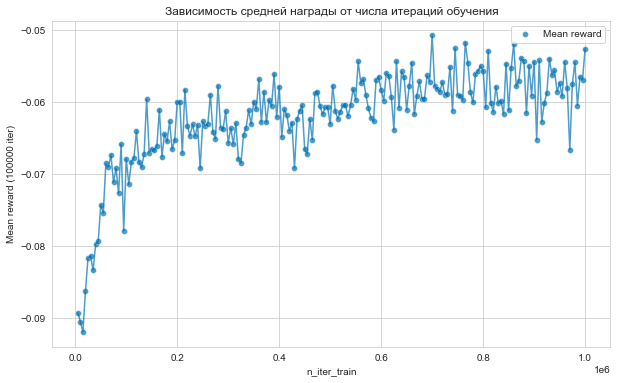

In [15]:
mc_control_player_best_params = OffPolicySoftGreedyMCControlPlayer(**grid_search_result['best_params'])
trainer.plot_learning(mc_control_player_best_params, max_iter_train=1000000, iter_train_step=5000, n_iter_check=100000)

Видно, что с ростом числа итераций игрок играет все лучше, и учить его нужно около 1кк итераций, однако выиграть у казино шансов нет, поскольку кривая выходит на плато.

**Добавить иллюстрацию стратегии, которую выучил игрок**

## Часть вторая, удвоенная

> В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки.

Итак, у игрока появляется дополнительное действие: **double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

Для начала реализуем окружение с возможность удвоения. Для этого скопируем код `BlackJackEnv` из [репозитория OpenAI](https://github.com/openai/gym), и немного модифицируем

In [57]:
from gym import spaces, Env
from gym.utils import seeding

class DoubleBlackjackEnv(Env):
    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab
        
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def stop_drawing(self):
        while self.sum_hand(self.dealer) < 17:
            self.dealer.append(self.draw_card(self.np_random))
        reward = self.cmp(self.score(self.player), self.score(self.dealer))
        if self.sab and self.is_natural(self.player) and not self.is_natural(self.dealer):
            # Player automatically wins. Rules consistent with S&B
            reward = 1.0
        elif (
            not self.sab
            and self.natural
            and self.is_natural(self.player)
            and reward == 1.0
        ):
            # Natural gives extra points, but doesn't autowin. Legacy implementation
            reward = 1.5
        return reward
    
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if self.is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2:
            self.player.append(self.draw_card(self.np_random))
            done = True
            if self.is_bust(self.player):
                reward = -1.0
            else:
                reward = self.stop_drawing()
            reward *= 2
                
        else:  # stick: play out the dealers hand, and score
            done = True
            reward = self.stop_drawing()
        return self._get_obs(), reward, done, {}
    
    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def reset(self):
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()
    
    def draw_card(self, np_random):
        return int(np_random.choice(self.deck))

    @staticmethod
    def cmp(a, b):
        return float(a > b) - float(a < b)
       
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    @staticmethod
    def usable_ace(hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21

    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)

    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21

    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

    @staticmethod
    def is_natural(hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]

In [58]:
double_env = DoubleBlackjackEnv(natural=True)
double_mc_control_player = OffPolicySoftGreedyMCControlPlayer(action_dim=3)
double_game = BlackJackGame(double_env)

In [12]:
double_trainer = Trainer(double_game)
double_trainer.train(double_mc_control_player, 50000)
double_game.mc_check(double_mc_control_player)

Training Player(gamma=1, eps=0.001):   0%|          | 0/50000 [00:00<?, ?it/s]

Checking Player(gamma=1, eps=0.001):   0%|          | 0/100000 [00:00<?, ?it/s]

-0.13029999999999717

In [13]:
# grid = {
#     'action_dim': [3],
#     'eps': [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75 ],
#     'gamma': [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1., 2]
# }

# grid_search_result = double_trainer.grid_search_params(double_mc_control_player, grid, printing=True, n_iter_train=100000, n_iter_check=100000,
#                            use_tqdm=True, use_tqdm_training=False, use_tqdm_checking=False)
# print(grid_search_result)

In [14]:
grid_search_result = {'best_params': {'action_dim': 3, 'eps': 0.01, 'gamma': 0.1}, 'best_reward': -0.03599000000000011}

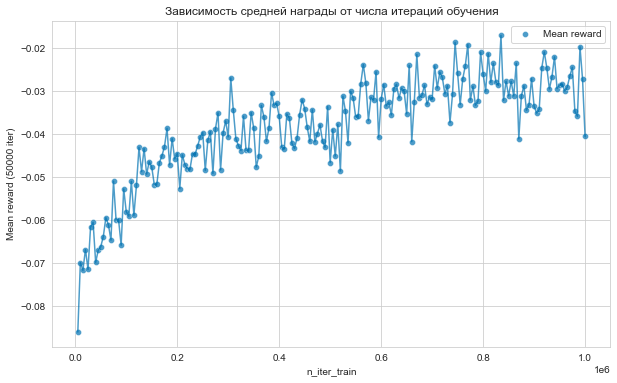

In [15]:
double_mc_control_player_best_params = OffPolicySoftGreedyMCControlPlayer(**grid_search_result['best_params'])
double_trainer.plot_learning(double_mc_control_player_best_params,
                      max_iter_train=1000000,
                      iter_train_step=5000,
                      n_iter_check=50000)

Видно, что удвоение позволяет игроку выигрывать еще чаще, но казино все еще в плюсе

**Добавить иллюстрацию итоговой стратегии** 

## Часть третья, в главной роли — Дастин Хоффман

> А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде

Наверное, лучший вариант, чтобы "реализовать" подсчет - это в качестве вектора состояния хранить какие карты вышли, а какие нет (полностью). Но тогда кажется, что пространство состояний сильно распухнет, и чтобы для всех возможных состояний набежало достаточно статистики по наградам - учиться придется очень долго. Поэтому для начала реализуем вариант подсчета "плюс-минус" или "половинки", описанный в [статье на вики](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA). Конечно не очень выглядит, что как будто `env` считает карты и выдает нам уже очки после вызова функции `draw_hand`, но выбор делать подсчет не в игроке, а в `env`-е, ни на что не влияет 

In [61]:
from gym import spaces, Env
from gym.utils import seeding

class DoubleBlackjackEnvWithCounting(Env):
    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab
        
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.temperature = 0
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def stop_drawing(self):
        while self.sum_hand(self.dealer) < 17:
            self.dealer.append(self.draw_card(self.np_random))
        reward = self.cmp(self.score(self.player), self.score(self.dealer))
        if self.sab and self.is_natural(self.player) and not self.is_natural(self.dealer):
            # Player automatically wins. Rules consistent with S&B
            reward = 1.0
        elif (
            not self.sab
            and self.natural
            and self.is_natural(self.player)
            and reward == 1.0
        ):
            # Natural gives extra points, but doesn't autowin. Legacy implementation
            reward = 1.5
        return reward
    
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if self.is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2:
            self.player.append(self.draw_card(self.np_random))
            done = True
            if self.is_bust(self.player):
                reward = -1.0
            else:
                reward = self.stop_drawing()
            reward *= 2
                
        else:  # stick: play out the dealers hand, and score
            done = True
            reward = self.stop_drawing()
        return self._get_obs(), reward, done, {}
    
    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player), self.temperature)

    def reset(self):
        if len(self.deck) < 15:
            self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
            self.temperature = 0
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()
    
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        self.deck.remove(card)
        self.temperature = self.update_temperature(card)
        return card
    
    def update_temperature(self, card):
        if card in (2, 7):
            temp_delta = 0.5
        elif card in (3, 4, 6):
            temp_delta = 1
        elif card == 5:
            temp_delta = 1.5
        elif card == 8:
            temp_delta = 0
        elif card == 9:
            temp_delta = -0.5
        elif card in (1, 10):
            temp_delta = -1
        else:
            raise ValueError(f'Look at wiki again - {card}')
        new_temperature = self.temperature + temp_delta
        return new_temperature

    @staticmethod
    def cmp(a, b):
        return float(a > b) - float(a < b)
       
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    @staticmethod
    def usable_ace(hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21

    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)

    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21

    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

    @staticmethod
    def is_natural(hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]

In [62]:
counting_env = DoubleBlackjackEnvWithCounting(natural=True)
counting_mc_control_player = OffPolicySoftGreedyMCControlPlayer(action_dim=3)
counting_game = BlackJackGame(counting_env)

In [63]:
counting_trainer = Trainer(counting_game)
counting_trainer.train(counting_mc_control_player, 50000)
counting_game.mc_check(counting_mc_control_player)

Training Player(gamma=1, eps=0.001):   0%|          | 0/50000 [00:00<?, ?it/s]

Checking Player(gamma=1, eps=0.001):   0%|          | 0/100000 [00:00<?, ?it/s]

-0.1310399999999986

In [66]:
# grid = {
#     'action_dim': [3],
#     'eps': [0.001, 0.005, 0.01, 0.05, 0.1, 0.25],
#     'gamma': [0.1, 0.25, 0.5, 0.75, 1.]
# }

# grid_search_result = counting_trainer.grid_search_params(counting_mc_control_player, grid, printing=True, n_iter_train=100000, n_iter_check=100000,
#                            use_tqdm=True, use_tqdm_training=False, use_tqdm_checking=False)
# print(grid_search_result)

In [67]:
best_params = {'best_params': {'action_dim': 3, 'eps': 0.001, 'gamma': 0.1}, 'best_reward': -0.086895}